In [238]:
import pandas as pd

In [239]:

data = pd.read_csv('C2T1_Train.csv')
print(data.head())
print(data.info())
for column in data.columns:
    print(f"Value counts for {column}:")
    print(data[column].value_counts())
    print("\n")
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()




C:\Users\Ethan Davis\AppData\Local\Temp\ipykernel_122436\538753166.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C2T1_Train.csv')


   encounter_id2  patient_nbr2  race gender       age  admission_type_id  \
0           5283      48330653     1      1   (80-90)                  2   
1           8499      63555809     1      1  (90-100)                  3   
2           9441      42519137     1      0   (40-50)                  1   
3          20997      89868902     2      1   (40-50)                  1   
4          28515      82637321     1      0   (50-60)                  2   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                         1                    4                13   
1                         3                    4                12   
2                         1                    7                 1   
3                         1                    7                 9   
4                         1                    2                 3   

  medical_specialty  ...  citoglipton  insulin  glyburide-metformin  \
0                 0  ...            0        1     

Feature Changing Non-Numerical Features to Numerical

In [240]:
import pandas as pd

train_df = pd.read_csv('C2T1_Train_Encoded.csv')
test_df = pd.read_csv('C2T1_Test_Encoded.csv')
X_train = train_df.drop(['readmitted'], axis=1)
y_train = train_df['readmitted']
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
gender_counts = train_df['gender'].value_counts()
print(train_df['gender'].unique())
print(gender_counts)

print("Non-numeric columns:", non_numeric_columns)
train_df['gender'] = pd.to_numeric(train_df['gender'], errors='coerce')
train_df = train_df.dropna(subset=['gender'])
train_df['gender'] = train_df['gender'].astype(int)

def convert_diag_to_int(diag_code):
    if pd.isnull(diag_code):
        return None 
    try:
       
        return int(diag_code.replace('.', ''))
    except ValueError:
        
        return None

for col in ['diag_1', 'diag_2', 'diag_3']:
    train_df[col] = train_df[col].apply(convert_diag_to_int)
train_df.dropna(subset=['diag_1', 'diag_2', 'diag_3'], inplace=True)
train_df.fillna(value=pd.Int64Dtype().na_value, inplace=True)
for col in ['diag_1', 'diag_2', 'diag_3']:
    train_df[col] = train_df[col].astype('Int64')
print(train_df[['diag_1', 'diag_2', 'diag_3']].head())

for col in ['diag_1', 'diag_2', 'diag_3']:
    test_df[col] = test_df[col].apply(convert_diag_to_int)
test_df.dropna(subset=['diag_1', 'diag_2', 'diag_3'], inplace=True)
test_df.fillna(value=pd.Int64Dtype().na_value, inplace=True)
for col in ['diag_1', 'diag_2', 'diag_3']:
    test_df[col] = test_df[col].astype('Int64')
print(test_df[['diag_1', 'diag_2', 'diag_3']].head())


C:\Users\Ethan Davis\AppData\Local\Temp\ipykernel_122436\1024303322.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('C2T1_Train_Encoded.csv')


[1 0 '1' '0' 'Unknown/Invalid']
gender
1                  26449
0                  22700
1                  22299
0                  19315
Unknown/Invalid        3
Name: count, dtype: int64
Non-numeric columns: Index(['gender', 'diag_1', 'diag_2', 'diag_3'], dtype='object')
   diag_1  diag_2  diag_3
0     398     427      38
1     434     198     486
2     197     157     250
3    2507     403     996
4     414     411     250
   diag_1  diag_2  diag_3
0     414     414     402
1     786     424     401
2     723     428     401
3     786     403     414
4     403     585      70


In [241]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = train_df.drop('readmitted', axis=1)

y = train_df['readmitted']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [242]:

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)
knn_predictions = knn_clf.predict(X_val_scaled)
knn_accuracy = accuracy_score(y_val, knn_predictions)
print(f'KNN Accuracy: {knn_accuracy}')


KNN Accuracy: 0.5292609265485213


In [243]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

label_mapping = {0: 0, 29: 1, 31: 2}
y_train_mapped = y_train.map(label_mapping)
y_val_mapped = y_val.map(label_mapping)
y_train_categorical = to_categorical(y_train_mapped, num_classes=3)
y_val_categorical = to_categorical(y_val_mapped, num_classes=3)
nn_model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train_categorical, epochs=10, batch_size=32, verbose=1)
nn_loss, nn_accuracy = nn_model.evaluate(X_val_scaled, y_val_categorical, verbose=0)
print(f'Neural Network Accuracy: {nn_accuracy}')

import numpy as np
nn_predictions_probs = nn_model.predict(X_val_scaled)
nn_predictions_class = np.argmax(nn_predictions_probs, axis=1)

Epoch 1/10
2194/2194 [==============================] - 3s 960us/step - loss: 0.9064 - accuracy: 0.5766
Epoch 2/10
2194/2194 [==============================] - 2s 953us/step - loss: 0.8855 - accuracy: 0.5874
Epoch 3/10
2194/2194 [==============================] - 2s 942us/step - loss: 0.8789 - accuracy: 0.5908
Epoch 4/10
2194/2194 [==============================] - 2s 949us/step - loss: 0.8745 - accuracy: 0.5951
Epoch 5/10
2194/2194 [==============================] - 2s 933us/step - loss: 0.8714 - accuracy: 0.5950
Epoch 6/10
2194/2194 [==============================] - 2s 930us/step - loss: 0.8677 - accuracy: 0.5975
Epoch 7/10
2194/2194 [==============================] - 2s 940us/step - loss: 0.8652 - accuracy: 0.5980
Epoch 8/10
2194/2194 [==============================] - 2s 934us/step - loss: 0.8612 - accuracy: 0.6008
Epoch 9/10
2194/2194 [==============================] - 2s 943us/step - loss: 0.8582 - accuracy: 0.6026
Epoch 10/10
2194/2194 [==============================] - 2s 937u

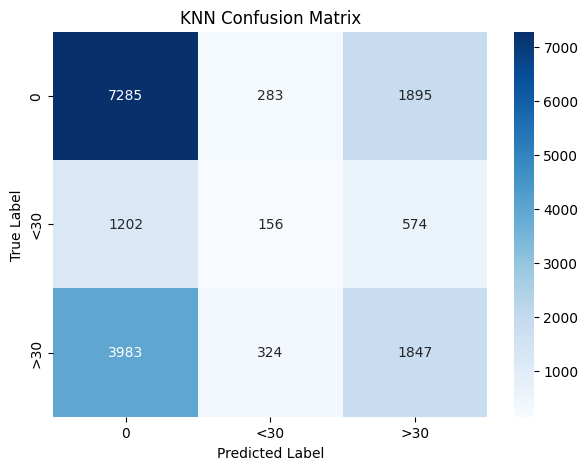

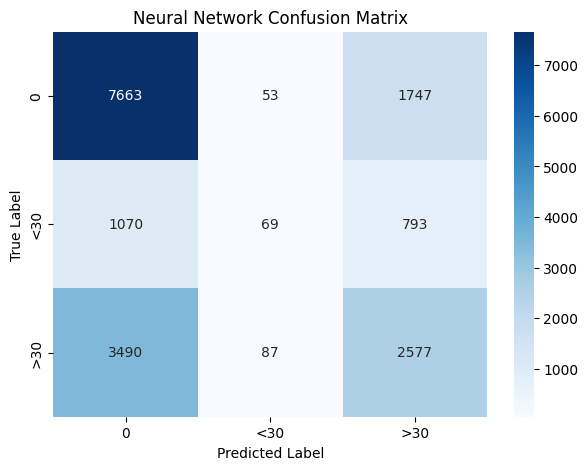

In [244]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, '<30', '>30'], yticklabels=[0, '<30', '>30'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
plot_confusion_matrix(y_val, knn_predictions, 'KNN Confusion Matrix')
plot_confusion_matrix(y_val_mapped, nn_predictions_class, 'Neural Network Confusion Matrix')